In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import datetime

In [3]:
import statsmodels.api as sm
import pandas as pd

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import files

In [5]:
def multilognorm(x):
  ans = 1
  for i in range(len(x)):
    ans *= st.lognorm.pdf(x[i],1,loc=0,scale=1)
    #ans *= np.exp(-np.log(x[i])**2/2)/(x[i]*np.sqrt(2*np.pi))
  return ans

def norm(x):
  ans = 1 
  for i in range(len(x)):
    ans *= np.exp(-(x[i])**2/2)/np.sqrt(2*np.pi)
  return ans

In [6]:
def finite_grid2(kappa,h):         # assume that the interval for each kappa_i is equal 
  dem = int(1/h - 1)         # assume that stepsize h always smaller or equal than .1
  b = np.linspace(0,1,int(1/h)+1)
  b = b[1:]
  b = b[:-1]
  A = np.zeros((dem,dem))
  a = np.linspace(0.1,1,len(kappa)+1)
  if h == .1:
    A[0,0] = -2*kappa[0]/(h**2)
    A[0,1] = kappa[0]/(h**2)
  else:
    A[0,0] = -2/(h**2)
    A[0,1] = 1/(h**2)
  for i in range(1,dem-1): 
    if i*h < 0.1:
      A[i,i] = -2/(h**2)
      A[i,i-1] = 1/(h**2)
      A[i,i+1] = 1/(h**2)
    else:
      s = i
      break
  t = 0
  for i in range(s,dem-1):
    if i*h >= a[t] and i*h < a[t+1]:
      A[i,i] = -2*kappa[t]/(h**2)
      A[i,i-1] = kappa[t]/(h**2) 
      A[i,i+1] = kappa[t]/(h**2) 
    else:
      t += 1
      A[i,i] = -2*kappa[t]/(h**2)
      A[i,i-1] = kappa[t]/(h**2) 
      A[i,i+1] = kappa[t]/(h**2) 
  A[-1,-1] = -2*kappa[-1]/(h**2)
  A[-1,-2] = kappa[-1]/(h**2)
  b[-1] -= 2*kappa[-1]/(h**2)
  ans = np.linalg.inv(A)@b
  x = []
  for i in range(len(ans)):
    if (i+1)*h in a:
      x.append(ans[i])
  return np.array(x)

k = np.random.lognormal(0,1,9)
#print(finite_grid2(k,0.01))
print(finite_grid2(k,0.05))

[0.14508011 0.29223517 0.45681565 0.66267996 0.86956058 1.2892108
 1.50652008 1.74509398]


In [43]:
def MH(m,d):    # m iterations/ d demension 
  x = np.zeros((m,d))
  k = 0
  x[0] = np.random.normal(0,1,d)
  e = np.random.lognormal(0,1,d)
  #e = np.exp(e)
  #e = np.exp(1/2)*np.ones(d)
      # e is the seed that used to generate data 
  data = finite_grid2(e,0.005) 
  for j in range(1,m):
    xt = x[j-1]
    y = xt+np.random.normal(0,0.64,d)
    s = np.random.rand(1)
    u = finite_grid2(np.exp(xt),0.005)
    v = finite_grid2(np.exp(y),0.005)
    r = multilognorm(np.exp(y))*np.exp((-np.linalg.norm(data-v))**2/2*10**(-5))/(multilognorm(np.exp(xt))*np.exp((-np.linalg.norm(data-u))**2/2*10**(-5)))
    #ratio = np.log(multilognorm(np.exp(y)))-np.log(multilognorm(np.exp(xt)))+((np.linalg.norm(data-u))**2)/(2*10**(-5))-((np.linalg.norm(data-v))**2)/(2*10**(-5))
                                # multilognorm is a function that I write to calcu the value of prior
                             
    
    if s <= min(1,r):
      x[j] = y
    else:
      x[j] = xt
      k+=1
  print('reject probablity: ' + str(k / m))
  #return np.exp(np.sum(x,axis=0)/m)
  
  x = np.exp(x)
  
  return x,e



In [44]:
start = datetime.datetime.now()
x2,da = MH(500000,9)
print(datetime.datetime.now()-start)




reject probablity: 0.638276
2:28:21.165387


In [ ]:
print(np.mean(x2,axis=0))

[0.60576501 0.59171742 0.59357755 0.60341805 0.61083134 0.59355482
 0.6096749  0.59954205 0.58835538]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  This is separate from the ipykernel package so we can avoid doing imports until


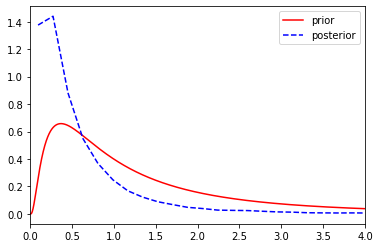

In [ ]:

tick = np.arange(x2[:,0].min(), x2[:,0].max(), 0.001)
p, y = np.histogram(x2[:,0], bins=100, normed=True)

plt.plot(y, p, '--b',label='posterior')
plt.xlim(0,4)
plt.legend()
#plt.savefig("1st_dim_of_kappai_by_MH.png")
#files.download("1st_dim_of_kappai_by_MH.png")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


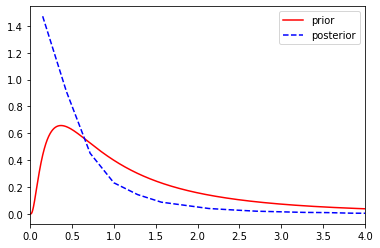

In [ ]:
tick = np.arange(x2[:,6].min(), x2[:,6].max(), 0.001)
p, y = np.histogram(x2[:,6], bins=100, normed=True)
plt.plot(tick, st.lognorm.pdf(tick,1),'r',label='prior')
y = (y[:-1] + y[1:])/2
plt.plot(y, p, '--b',label='posterior')
plt.xlim(0,4)
plt.legend()
c
plt.show()

In [ ]:
t0 = sm.tsa.acf(x2[:,2])
t1 = sm.tsa.acf(x2[:,1])
print(t0)
print(t1)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


[1.         0.91657987 0.84059291 0.76894861 0.70563335 0.64801155
 0.59442262 0.54526043 0.50360606 0.4672733  0.43352022 0.40153247
 0.37086909 0.34322636 0.31702627 0.2925828  0.26985222 0.24929802
 0.23153341 0.21477681 0.19865829 0.18139193 0.16577732 0.15205469
 0.13972205 0.12820512 0.11693488 0.10699348 0.09866056 0.09156869
 0.08529135 0.07872651 0.07150366 0.06509171 0.05897663 0.05349923
 0.04887724 0.04442877 0.04009048 0.03644133 0.03351486]
[1.         0.91472501 0.84058497 0.77393027 0.71381129 0.6605571
 0.60939368 0.562311   0.51827192 0.47987717 0.44514594 0.41180159
 0.38010846 0.34959932 0.32178938 0.29778629 0.27527871 0.25310421
 0.23340001 0.21523003 0.19905595 0.18426851 0.1721058  0.16046971
 0.149384   0.13940054 0.12933185 0.1215424  0.11423743 0.10730735
 0.10127255 0.09474044 0.08843362 0.08233879 0.0773885  0.07311303
 0.07004499 0.06721572 0.06468818 0.06128986 0.05768262]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

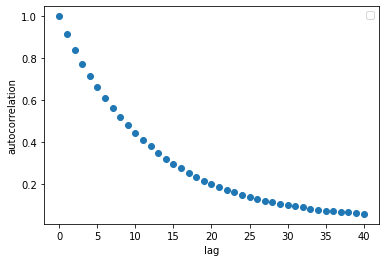

In [ ]:
l = np.arange(len(t1))
plt.scatter(l,t1)
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.legend()
plt.savefig("atuoco_2nd_dim_by_MH.png")
files.download("atuoco_2nd_dim_by_MH.png")
plt.show()

In [ ]:
plt.scatter(l,t1)
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.title('1st dem of 2-dem')

In [ ]:
x6 = MH(100000,9)
x3 = MH(100000,9)
x4 = MH(100000,9)
x5 = MH(100000,9)
D= 10000
J =5
L =100000-D
x20 = x2[D:,0]
x30 = x3[D:,0]
x40 = x4[D:,0]
x50 = x5[D:,0]
x60 = x6[D:,0]   # discard 1st 1000 values

x_2 = np.mean(x20)
x_3 = np.mean(x30)
x_4 = np.mean(x40)
x_5 = np.mean(x50)
x_6 = np.mean(x60) # for each chain, calcu their mean 
xd = (x_2+x_3+x_4+x_5+x_6)/5  # grand mean 
print(xd)
B = L*((x_2-xd)**2+(x_3-xd)**2+(x_4-xd)**2+(x_5-xd)**2+(x_6-xd)**2)/(J-1)   # between chain variance 
print(B)
s2 = np.std(x2)**2
s3 = np.std(x3)**2
s4 = np.std(x4)**2
s5 = np.std(x5)**2
s6 = np.std(x6)**2     # within chain variance 
print(s2,s3,s4,s5,s6)
W = (s2+s3+s4+s5+s6)/5
R= (L-1)*W/L+B/L
R=R/W
R   #GR stats 

[2.6839364  0.95846569 2.22786453 0.40947762 0.64840228 1.24276024
 0.86445234 0.97491395 2.56245216]
reject probablity: 0.63835
[1.94940112 0.22411784 0.26139846 0.24489786 1.18660931 1.36746991
 0.12646819 0.36642576 2.7671304 ]
reject probablity: 0.63734
[0.60277047 2.90957728 1.62625526 0.1914856  1.07377788 1.78568738
 0.21693605 0.07487037 1.17944416]
reject probablity: 0.64064
[0.57739292 1.75401924 1.93398371 0.09878893 0.97934738 1.66821655
 7.38682705 2.55200781 0.16587512]
reject probablity: 0.64072
0.6017744711064529
7.142137723662959
0.5966809886492767 0.6578548666341982 0.5907239213274394 0.6201726933015821 0.6472012685494345


1.0001163646738453

In [ ]:
#########################

In [41]:
def algo1(m,d,d2):
  x = np.zeros((m,d))
  k = 0
  x[0] = np.random.normal(0,1,d)
  #e = np.random.lognormal(0,1,d)
  i = 0
  #print(e)
  data = finite_grid2(d2,0.005) #####
  for j in range(1,m):
    xt = x[j-1]
    y = xt+np.random.normal(0,0.64,d)
    s = np.random.rand(1)
    u = finite_grid2(np.exp(xt),0.02)
    v = finite_grid2(np.exp(y),0.02)
    r = multilognorm(np.exp(y))*np.exp((-np.linalg.norm(data-v))**2/2*10**(-5))/(multilognorm(np.exp(xt))*np.exp((-np.linalg.norm(data-u))**2/2*10**(-5)))
                                
    if s >= min(1,r):
      x[j] = xt
      k += 1
    else:
      
      u = finite_grid2(np.exp(xt),0.005)
      v = finite_grid2(np.exp(y),0.005)
      r = multilognorm(np.exp(y))*np.exp((-np.linalg.norm(data-v))**2/2*10**(-5))/(multilognorm(np.exp(xt))*np.exp((-np.linalg.norm(data-u))**2/2*10**(-5)))
      ss = np.random.rand(1)
      if ss >= min(1,r):
        x[j] = xt
        i += 1
      else:
       x[j] = y
      
  print('reject probablity: ' + str(k / m))
  x = np.exp(x)
  print(k,i)
  return x

In [45]:
start = datetime.datetime.now()
x = algo1(500000,9,da)
print(datetime.datetime.now()-start)
print(np.mean(x,axis=0))

reject probablity: 0.680446
340223 56104
1:58:00.102839
[0.47068291 0.47162151 0.47692769 0.47039031 0.47085387 0.47305381
 0.48119341 0.4711786  0.47172771]


In [1]:
t = np.arange(x[:,0].min(),x[:,0].max(),0.001)
p, y = np.histogram(x[:,0], bins=100, normed=True)
plt.plot(t, st.lognorm.pdf(t,1),'r',label='standard lognormal')
y = (y[:-1] + y[1:])/2
plt.plot(y, p, '--b',label='Algorithm 1')
q, z = np.histogram(x2[:,0],bins=100,normed=True)
z = (z[:-1] + z[1:])/2
plt.plot(z,q,'--g',label='MH algorithm')
plt.xlim(0,4)
plt.legend()
#plt.savefig("comparison_of_dim1.png")
#files.download("comparison_of_dim1.png")
plt.show


NameError: ignored

In [ ]:
print(sm.tsa.acf(x[:,0]))
print(sm.tsa.acf(x[:,1]))
print(sm.tsa.acf(x[:,2]))

In [ ]:
t1 = sm.tsa.acf(x[:,0])
t2 = sm.tsa.acf(x[:,1])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

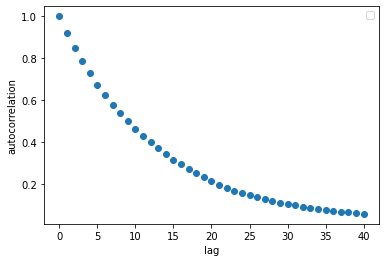

In [ ]:
l = np.arange(len(t2))
plt.scatter(l,t2)
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.legend()
plt.savefig("atuoco_2nd_dim_by_Algo1.png")
files.download("atuoco_2nd_dim_by_Algo1.png")
plt.show()

In [ ]:
x6 = algo1(100000,9)
x3 = algo1(100000,9)
x4 = algo1(100000,9)
x5 = algo1(100000,9)

[0.71494368 2.98255938 0.99777254 1.2275437  0.44932062 0.91798512
 1.42114038 2.28873482 0.43680291]
reject probablity: 0.68211
68211 11028
[0.29198949 0.34411919 1.4098066  1.05066826 7.07420041 0.59749616
 1.53875113 0.84294289 0.53551976]
reject probablity: 0.67923
67923 11076
[2.05692691 1.33447617 0.73279836 0.9594425  0.5479292  0.39914569
 2.35070131 1.26136808 1.13591445]
reject probablity: 0.68001
68001 11293
[6.03955381 2.94453864 1.728285   0.45046262 4.50541948 2.20730933
 0.07469815 0.35848641 0.55941135]
reject probablity: 0.67992
67992 11243


In [ ]:
D= 10000
J =5
L =100000-D
x21 = x[D:,0]
x31 = x3[D:,1]
x41 = x4[D:,1]
x51 = x5[D:,1]
x61 = x6[D:,1]   # discard 1st 1000 values

x_2 = np.mean(x21)
x_3 = np.mean(x31)
x_4 = np.mean(x41)
x_5 = np.mean(x51)
x_6 = np.mean(x61) # for each chain, calcu their mean 
xd = (x_2+x_3+x_4+x_5+x_6)/5  # grand mean 
print(xd)
B = L*((x_2-xd)**2+(x_3-xd)**2+(x_4-xd)**2+(x_5-xd)**2+(x_6-xd)**2)/(J-1)   # between chain variance 
print(B)
s2 = np.std(x)**2
s3 = np.std(x3)**2
s4 = np.std(x4)**2
s5 = np.std(x5)**2
s6 = np.std(x6)**2     # within chain variance 
print(s2,s3,s4,s5,s6)
W = (s2+s3+s4+s5+s6)/5
R= (L-1)*W/L+B/L
R=R/W
R  

0.4700707635281797
3.1639977298108177
0.14418047679335155 0.14936732546228257 0.14445776806390365 0.13964799010380802 0.14726759549995752


1.0002313671918324

Text(0.5, 1.0, '1st dem of 2-dem')

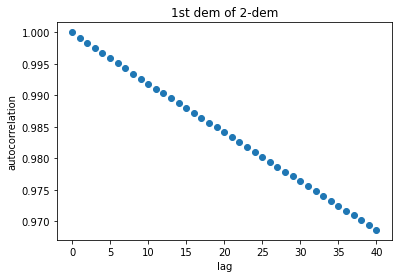

In [ ]:
l = np.arange(len(t1))
plt.scatter(l,t1)
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.title('1st dem of 2-dem')

Text(0.5, 1.0, '2nd dem of 2-dem')

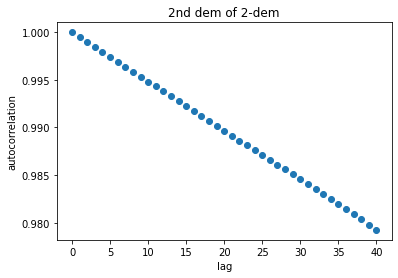

In [ ]:
plt.scatter(l,t3)
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.title('2nd dem of 2-dem')

Text(0.5, 1.0, '2nd dem of 2-dem')

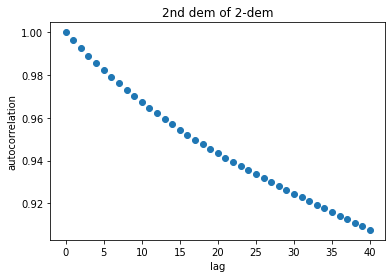

In [ ]:
plt.scatter(l,t4)
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.title('2nd dem of 2-dem')